In [1]:
import numpy as np
from scipy.fftpack import dct, idct

import scipy.io
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from helper_functions.helper_functions import plt3D2

import svd_model as svm

import forward_model as fm
import cv2 as cv

# Field-varying forward model

In this notebook, you can upload your measured PSFs across the FoV. At each depth, the measured PSFs will be registered and the SVD parameters will be computed. These parameters (comps, weights) can be used to generate simulated measurements taking into account field varying aberrations. In our experiments, we measure an 8x8 grid (64 PSFs) at each depth and use rank 12. In this tutorial, we include a downsampled version measured on a 3x3 grid (9 PSFs) at 40 depths. 


## Load in measured PSFs

PSFs are expected to have a shape of (x,y,P,z), where P is the number of samples at a given depth, and z is the number of depths. Here PSFs have a shape of (486, 648, 9, 40).

In [2]:
# kyrollos' nonsense hardcoded path
#registered_psfs_path = '/home/kyrollos//LearnedMiniscope3D/MultiWiener/multiwienernet/data/PSFs/9_psfs/multiWienerPSFStack_40z.mat'

#my nonsense hardcoded path:
registered_psfs_path = '/home/dshteinbok/LearnedMiniscope2D/MultiWiener/multiwienernet/data/PSFs/9_psfs/multiWienerPSFStack_40z_aligned.mat'

psf_name='multiWienerPSFStack_40z'

loaded_matfile = scipy.io.loadmat(registered_psfs_path)
loaded_matfile

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue May 11 17:48:00 2021',
 '__version__': '1.0',
 '__globals__': [],
 'multiWienerPSFStack_40z': array([[[[ 1.41666667, -0.5       , -2.33333333, ...,  0.66666667,
           -2.16666667, -2.41666667],
          [-0.5       ,  0.83333333, -0.16666667, ..., -1.41666667,
            1.        ,  1.33333333],
          [ 0.75      ,  1.83333333, -0.75      , ..., -1.33333333,
           -2.33333333, -2.91666667],
          ...,
          [-1.25      , -1.08333333, -0.16666667, ..., -2.33333333,
           -0.83333333,  1.5       ],
          [ 2.5       , -1.83333333, -0.25      , ..., -0.08333333,
           -0.25      ,  0.08333333],
          [-1.41666667, -2.5       , -2.        , ..., -1.91666667,
            1.16666667, -4.58333333]],
 
         [[-2.25      ,  2.08333333,  0.91666667, ..., -1.91666667,
            2.25      , -1.75      ],
          [ 3.25      , -4.16666667,  3.66666667, ..., -1.        ,
      

In [3]:
type(loaded_matfile)

dict

In [4]:
psfs=loaded_matfile[psf_name]
print(psfs.shape)

(486, 648, 9, 40)


## Registering the PFSs

In order to calcualte SVD model parameters, we need to register the PSFs. This registration is done at each depth. We pick the PSF sampled from the middle of the FoV as the reference image and register other PSFs to it. Here we show how this is done at one depth (z=0). If wokring with 3D PSFs, you will need to repeat this for each depth. 

In addition, if the PFSs contain some background, we implement a discrete cosine transform background subtraction. This is tuned to our PSFs and is optional. Set dct_on=True or False to enable or disable it. 

In [5]:
# register the PSFs and calculate their shifts
depth=0
ref_image_index=4
psfs_reg,shifts=svm.register_psfs(psfs[:,:,:,depth],psfs[:,:,ref_image_index,depth],dct_on=True)

Removing background

done

registering

done registering



In [6]:
psfs[:,:,:,depth].shape

(486, 648, 9)

In [7]:
psfs[:,:,ref_image_index,depth].shape

(486, 648)

## Calculating SVD model parameters

Using the registered PSFs and the shifts, we can now perfrom SVD up to a chosen rank less thank the number of image sampled per depth. Here we have 9 images per depth, so we chose a rank of 4. The higher the rank, the better the model but the slower the FISTA SVD algorithm. 

In [8]:
rank=4
#rank=24
comps, weights_interp=svm.calc_svd(psfs_reg,shifts,rank)

creating matrix

done

starting svd...

check values of ymat
interpolating...

done




In [9]:
comps.shape

(486, 648, 4)

## Let's visualize the weights and components


In [10]:
plt3D2(comps)

interactive(children=(IntSlider(value=1, description='r', max=3), Output()), _dom_classes=('widget-interact',)…

In [11]:
plt3D2(weights_interp)

interactive(children=(IntSlider(value=1, description='r', max=3), Output()), _dom_classes=('widget-interact',)…

## simulate data using forward model

In [12]:
#make the shape, xyzr or xyr if 2D
# Normalize weights to have maximum sum through rank of 1
weights_norm = np.sum(weights_interp[weights_interp.shape[0]//2-1,weights_interp.shape[1]//2-1,:],0).max()
weights = weights_interp/weights_norm;

#normalize by norm of all stack. Can also try normalizing by max of all stack or by norm of each slice
h=comps/np.linalg.norm(np.ravel(comps))

In [13]:
np.sum(weights_interp[weights_interp.shape[0]//2-1,weights_interp.shape[1]//2-1,:],0)

623.6973483775199

In [14]:
weights_interp[weights_interp.shape[0]//2-1,weights_interp.shape[1]//2-1,:]

array([ 616.86606623, -353.86337441,  277.82156572,   82.87309083])

In [15]:
# padded values for 2D
ccL = np.shape(h)[1]//2
ccU = 3*np.shape(h)[1]//2
rcL = np.shape(h)[0]//2
rcU = 3*np.shape(h)[0]//2

H=np.ndarray((np.shape(h)[0]*2,np.shape(h)[1]*2,np.shape(h)[2]), dtype=complex)
Hconj=np.ndarray((np.shape(h)[0]*2,np.shape(h)[1]*2,np.shape(h)[2]),dtype=complex)
for i in range (np.shape(h)[2]):
        H[:,:,i]=(np.fft.fft2(fm.pad2d(h[:,:,i])))
        Hconj[:,:,i]=(np.conj(H[:,:,i]))

In [16]:
x=(plt.imread('/home/dshteinbok/MultiWienerNet/data/hydra3.jpg'))
# x=(plt.imread('/home/kyrollos/MultiWienerNet/data/hydra3.jpg'))
x=cv.resize(x,(h.shape[1],h.shape[0]))
x=np.mean(x,2)

In [17]:
sim=fm.A_2d_svd_crop(fm.pad2d(x),H,weights,fm.pad2d,[rcL,rcU,ccL,ccU],mode='shift_variant')

Text(0.5, 1.0, 'Simulated Measurement')

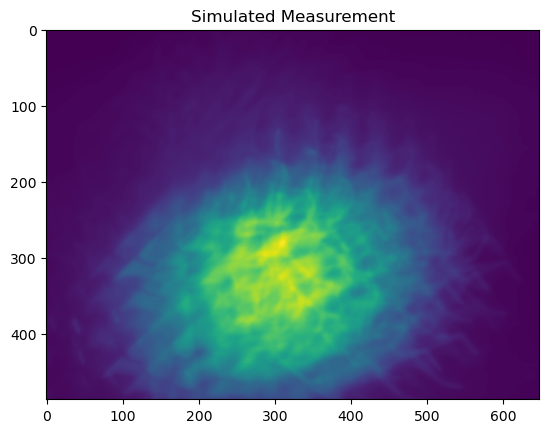

In [18]:
plt.imshow(sim)
plt.title('Simulated Measurement')

Now, the real question is whether the SVD done by the code above produces the same thing that the authors provided to us via Google Drive. I hereby test this. First with the explicitly-called `H` and `weights`

In [19]:
import sys
sys.path.append("../tensorflow")
import forward_model_tf as fm_tf

H_loaded,weights_loaded,_ =fm_tf.load_weights(h_path='../data/SVD_2_5um_PSF_5um_1_ds4_dsz1_comps_green_SubAvg.mat',
                                      weights_path='../data/SVD_2_5um_PSF_5um_1_ds4_dsz1_weights_green_SubAvg.mat') 

In [20]:
H==H_loaded

/tmp/ipykernel_1461821/3893377619.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  H==H_loaded


False

In [21]:
H.shape

(972, 1296, 4)

In [22]:
H_loaded.shape

(972, 1296, 12)

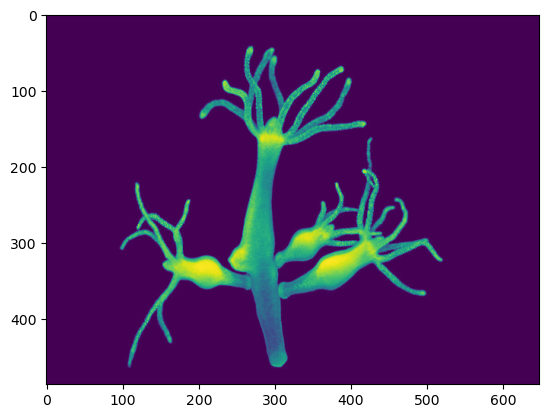

In [25]:
plt.imshow(x)

In [26]:
crop_indices = [rcL,rcU,ccL,ccU]

In [27]:
sim2 = fm_tf.sim_data(x,H,weights,crop_indices)

need `crop_indices`... what are those? They are generated in `forward_model_tf`. **TODO** examine `forward_model_tf` for how it loads weights etc. and what it actually returns.

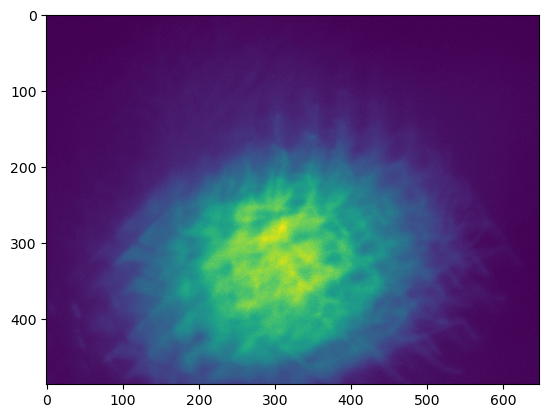

In [28]:
plt.imshow(sim2)

In [29]:
sim==sim2

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [30]:
sim

array([[ 101.1137025 ,  101.67286208,  102.09652754, ...,   74.29822286,
          71.93869115,   68.41725722],
       [ 100.990653  ,  101.46600185,  101.20976867, ...,   76.79676674,
          76.19132484,   72.53185504],
       [ 100.71179874,  100.68707211,  100.23076483, ...,   79.26367731,
          79.29151868,   74.85837791],
       ...,
       [1152.82561438, 1132.01401963, 1115.38809593, ...,  350.46194251,
         350.70675072,  354.05839673],
       [1155.71665708, 1125.6303334 , 1100.73695694, ...,  345.11344634,
         347.50913929,  349.59301821],
       [1156.76266211, 1114.68941834, 1078.14190622, ...,  340.26466634,
         344.13687092,  347.36449608]])

In [31]:
sim2

array([[0.00172891, 0.00633341, 0.        , ..., 0.        , 0.        ,
        0.00588733],
       [0.00473752, 0.        , 0.00359414, ..., 0.00306322, 0.0048072 ,
        0.        ],
       [0.00626445, 0.00345285, 0.01005546, ..., 0.0058078 , 0.00965154,
        0.00964209],
       ...,
       [0.03075194, 0.03548933, 0.0453422 , ..., 0.01121335, 0.00997623,
        0.0154583 ],
       [0.03579358, 0.04453511, 0.03076482, ..., 0.0140945 , 0.01243234,
        0.0071345 ],
       [0.03832082, 0.02374664, 0.03475267, ..., 0.01091696, 0.00942562,
        0.01885323]])

`sim2` has smaller values than `sim`, as though `sim2` is normalized... 

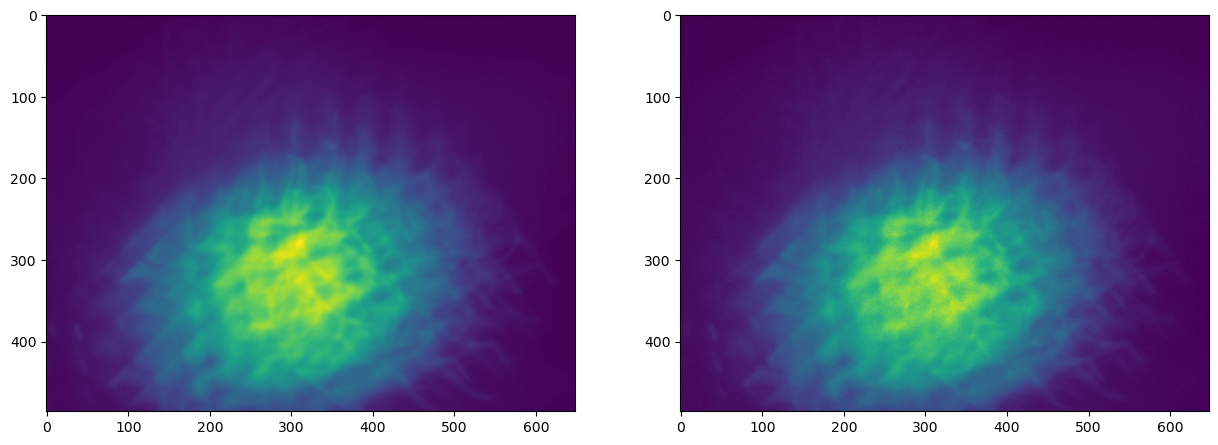

In [36]:
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(sim)
ax[1].imshow(sim2)

I mean... seems good enough. Image on the right uses the tensorflow forward model which I would use in general. It has clearer features and smaller values.

### Checking the load_model post-processing
Now, let's actually compare in one go the stuff that we've done here to generate the `H` and `weights`, and what is done by `fm_tf.load_model` after actually loading the files. To do that I'll just copy-paste in the function from there, modify it to take `h` and `weights` generated by `calc_svd`. Then I'll compare the output of that to the `H`, `crop_indices` and `weights` generated.

In [46]:
def pad2d (x):
    Ny=np.shape(x)[0]
    Nx=np.shape(x)[1]
    return np.pad(x,((Ny//2,Ny//2),(Nx//2,Nx//2)),'constant', constant_values=(0))

def pad4d(x):
    Ny=np.shape(x)[0]
    Nx=np.shape(x)[1]
    return np.pad(x,((Ny//2,Ny//2),(Nx//2,Nx//2),(0,0),(0,0)),'constant', constant_values=(0))

def crop4d(x,rcL,rcU,ccL,ccU):
    return x[rcL:rcU,ccL:ccU,:,:]

def crop2d(x,rcL,rcU,ccL,ccU):   
    return x[rcL:rcU,ccL:ccU]

def nocrop(x):
    return x

def nopad(x):
    return x

def A_2d_svd(x,H,weights,pad,mode='shift_variant'): #NOTE, H is already padded outside to save memory
    x=pad(x)
    Y=np.zeros((np.shape(x)[0],np.shape(x)[1]))
        
    if (mode =='shift_variant'):
        for r in range (0,np.shape(weights)[2]):
            X=np.fft.fft2((np.multiply(pad(weights[:,:,r]),x)))
            Y=Y+ np.multiply(X,H[:,:,r])
    
    return np.real((np.fft.ifftshift(np.fft.ifft2(Y))))

def A_2d(x,psf,pad):
    X=np.fft.fft2((pad(x)))
    H=np.fft.fft2((pad(psf)))
    Y=np.multiply(X,H)
    
    return np.real((np.fft.ifftshift(np.fft.ifft2(Y))))

def A_2d_adj_svd(Hconj,weights,y,pad):
    y=pad(y)
    x=np.zeros((np.shape(y)[0],np.shape(y)[1]))
    for r in range (0, np.shape(weights)[2]):
        x=x+np.multiply(pad(weights[:,:,r]),(np.real(np.fft.ifftshift(np.fft.ifft2(np.multiply(Hconj[:,:,r], np.fft.fft2((y))))))))
    #note the weights are real so we dont take the complex conjugate of it, which is the adjoint of the diag 
    return x

def A_2d_adj(y,psf,pad):
    H=np.fft.fft2((pad(psf)))
    Hconj=np.conj(H)
    x=(np.real(np.fft.ifftshift(np.fft.ifft2(np.multiply(Hconj, np.fft.fft2((pad(y))))))))
    
    return x

def A_3d(x,h,pad):
    #h is the psf stack
    #x is the variable to convolve with h
    x=pad(x)
    B=np.zeros((np.shape(x)[0],np.shape(x)[1]))
        

    for z in range (0,np.shape(h)[2]):
        #X=np.fft.fft2((np.multiply(pad(weights[:,:,z]),x)))
        B=B+ np.multiply(np.fft.fft2(x[:,:,z]),np.fft.fft2(pad(h[:,:,z])))
    
    return np.real((np.fft.ifftshift(np.fft.ifft2(B))))


def A_3d_svd(v,alpha,H,pad):
    #alpha is Ny-Nx-Nz-Nr, weights
    #v is Ny-Nx-Nz
    #H is Ny-Nx-Nz-Nr
    # b= sum_r (sum_z (h**alpra.*v))
    b=np.zeros((np.shape(v)[0],np.shape(v)[1]))
    for r in range (np.shape(H)[3]):
        for z in range (np.shape(H)[2]):
            b=b+np.multiply(H[:,:,z,r],np.fft.fft2(np.multiply(v[:,:,z],alpha[:,:,z,r])))
    
    return np.real(np.fft.ifftshift(np.fft.ifft2(b)))

def A_3d_adj(x,h,pad):
    y=np.zeros(np.shape(h))
    X=np.fft.fft2(pad(x))
    for z in range(np.shape(h)[2]):
        H=np.conj(np.fft.fft2(pad(h[:,:,z])))
        y[:,:,z]=np.real(np.fft.ifftshift(np.fft.ifft2(np.multiply(H,X))))
    return y

def A_3d_adj_svd(b,alpha,Hconj,pad):
    #y=sum_r(alpha.*H_conj**b)
    y=np.zeros((np.shape(alpha)[0],np.shape(alpha)[1],np.shape(alpha)[2]))
    B=np.fft.fft2(pad(b))
    for z in range(np.shape(alpha)[2]):
        for r in range(np.shape(alpha)[3]):
            y[:,:,z]=y[:,:,z]+np.multiply(alpha[:,:,z,r],np.fft.ifftshift(np.fft.ifft2(np.multiply(B,Hconj[:,:,z,r]))))
        
    return y

def grad(v):
    return np.array(np.gradient(v))  #returns gradient in x and in y


def grad_adj(v):  #adj of gradient is negative divergence
    z = np.zeros((n,n)) + 1j
    z -= np.gradient(v[0,:,:])[0]
    z -= np.gradient(v[1,:,:])[1]
    return z

def load_weights_postprocess(h, weights):
    # we don't need to load the files
    #h=scipy.io.loadmat(h_path) 
    #weights=scipy.io.loadmat(weights_path )

    # depth_plane is not used, since h and weights are 3D rather than 4D
    depth_plane=0 #NOTE Z here is 1 less than matlab file as python zero index. So this is z31 in matlab

    # again, no need do access data of what would have been a dict
    #h=h['array_out']
    #weights=weights['array_out']
    
    # we aren't swapping anything, since it's already (x,y,r)
    ## make sure its (x,y,z,r)
    #h=np.swapaxes(h,2,3)
    #weights=np.swapaxes(weights,2,3)

    #h=h[:,:,depth_plane,:]
    #weights=weights[:,:,depth_plane,:]

    # Normalize weights to have maximum sum through rank of 1
    weights_norm = np.max(np.sum(weights[np.shape(weights)[0]//2-1,np.shape(weights)[1]//2-1,:],0))
    weights = weights/weights_norm;

    #normalize by norm of all stack. Can also try normalizing by max of all stack or by norm of each slice
    h=h/np.linalg.norm(np.ravel(h))

    # padded values for 2D

    ccL = np.shape(h)[1]//2
    ccU = 3*np.shape(h)[1]//2
    rcL = np.shape(h)[0]//2
    rcU = 3*np.shape(h)[0]//2

    H=np.ndarray((np.shape(h)[0]*2,np.shape(h)[1]*2,np.shape(h)[2]), dtype=complex)
    Hconj=np.ndarray((np.shape(h)[0]*2,np.shape(h)[1]*2,np.shape(h)[2]),dtype=complex)
    for i in range (np.shape(h)[2]):
        H[:,:,i]=(np.fft.fft2(pad2d(h[:,:,i])))
        Hconj[:,:,i]=(np.conj(H[:,:,i]))
    return H,weights,[rcL,rcU,ccL,ccU]

In [47]:
H_post, weights_post, croppings_post = load_weights_postprocess(h, weights)

In [55]:
croppings_post==crop_indices

True

From above, it appears that **all you have to do is perform:** 
```python
psfs_reg,shifts=svm.register_psfs(psfs[:,:,:,depth],psfs[:,:,ref_image_index,depth],dct_on=True)
comps, weights_interp=svm.calc_svd(psfs_reg,shifts,rank)
#make the shape, xyzr or xyr if 2D
# Normalize weights to have maximum sum through rank of 1
weights_norm = np.sum(weights_interp[weights_interp.shape[0]//2-1,weights_interp.shape[1]//2-1,:],0).max()
weights = weights_interp/weights_norm;

#normalize by norm of all stack. Can also try normalizing by max of all stack or by norm of each slice
h=comps/np.linalg.norm(np.ravel(comps))

H, weights, crop_indices = load_weights_postprocess(h, weights)
```

And then `H`, `weights`, `crop_indices` can be passed to `fm_tf.sim_data` with no problem.

In [56]:
H_post.shape

(972, 1296, 4)

In [57]:
weights_post.shape

(486, 648, 4)

In [59]:
croppings_post

[243, 729, 324, 972]

In [63]:
scipy.io.loadmat("/home/dshteinbok/MultiWienerNet/data/SVD_2_5um_PSF_5um_1_ds4_dsz1_comps_green_SubAvg.mat")

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Apr  5 19:38:32 2020',
 '__version__': '1.0',
 '__globals__': [],
 'array_out': array([[[[-9.61634578e-06, -2.95029931e-05, -3.70478892e-06, ...,
           -2.75180332e-06,  2.08961319e-05, -1.16309402e-05],
          [ 1.93623957e-04, -4.05221399e-05,  6.41796432e-05, ...,
            2.20371821e-05,  6.91560490e-05, -1.36428454e-04],
          [-7.05143384e-06, -9.40289319e-05, -4.35726070e-05, ...,
            2.57039152e-04,  4.58934555e-05,  1.86793215e-04],
          ...,
          [ 3.54177726e-04, -1.60209325e-04,  7.69569597e-05, ...,
            2.57454667e-04, -2.39278233e-04,  3.30965733e-04],
          [ 1.55239707e-06, -9.76458250e-05, -9.32702096e-06, ...,
           -1.24103375e-04, -2.84879177e-04,  7.98760215e-04],
          [ 7.74396613e-05, -2.18573514e-05, -3.17174708e-04, ...,
            1.84292032e-04, -3.05502763e-04,  1.04773899e-04]],
 
         [[ 4.91249702e-05, -4.23747879e-05, -3.14